# Pre-requisits
- "Models training helpers.ipynb" should be contained in the same directory as this file
    in order to run command ' %run "Models training helpers.ipynb" sort=False ' and utilize the helpers
- Glove should be downloaded to local directory './Data/Iterative-models-building/Training data/glove.6B.100d.t
    this is where Models training helpers.ipynb will pick it up 
    
    
- to investigate, re version control: https://towardsdatascience.com/version-control-with-jupyter-notebooks-f096f4d7035a


<h1>Iterative Model Building - Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pre-requisits" data-toc-modified-id="Pre-requisits-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pre-requisits</a></span></li><li><span><a href="#Callibration" data-toc-modified-id="Callibration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Callibration</a></span></li><li><span><a href="#Start" data-toc-modified-id="Start-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Start</a></span></li><li><span><a href="#Iterative-Model-building-User-interface-Class" data-toc-modified-id="Iterative-Model-building-User-interface-Class-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Iterative Model building User interface Class</a></span></li><li><span><a href="#END" data-toc-modified-id="END-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>END</a></span></li><li><span><a href="#Retrain-the-models" data-toc-modified-id="Retrain-the-models-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Retrain the models</a></span></li><li><span><a href="#Get-Stopwords" data-toc-modified-id="Get-Stopwords-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Get Stopwords</a></span></li><li><span><a href="#Store-DL-models-in-a-pickle-file" data-toc-modified-id="Store-DL-models-in-a-pickle-file-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Store DL models in a pickle file</a></span></li><li><span><a href="#Code-to-Transform-original-training-data-to-new-format---we-just-need-to-run-this-once-as-this-data-is-static." data-toc-modified-id="Code-to-Transform-original-training-data-to-new-format---we-just-need-to-run-this-once-as-this-data-is-static.-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Code to Transform original training data to new format - we just need to run this once as this data is static.</a></span></li></ul></div>

Necessary libraries imported.


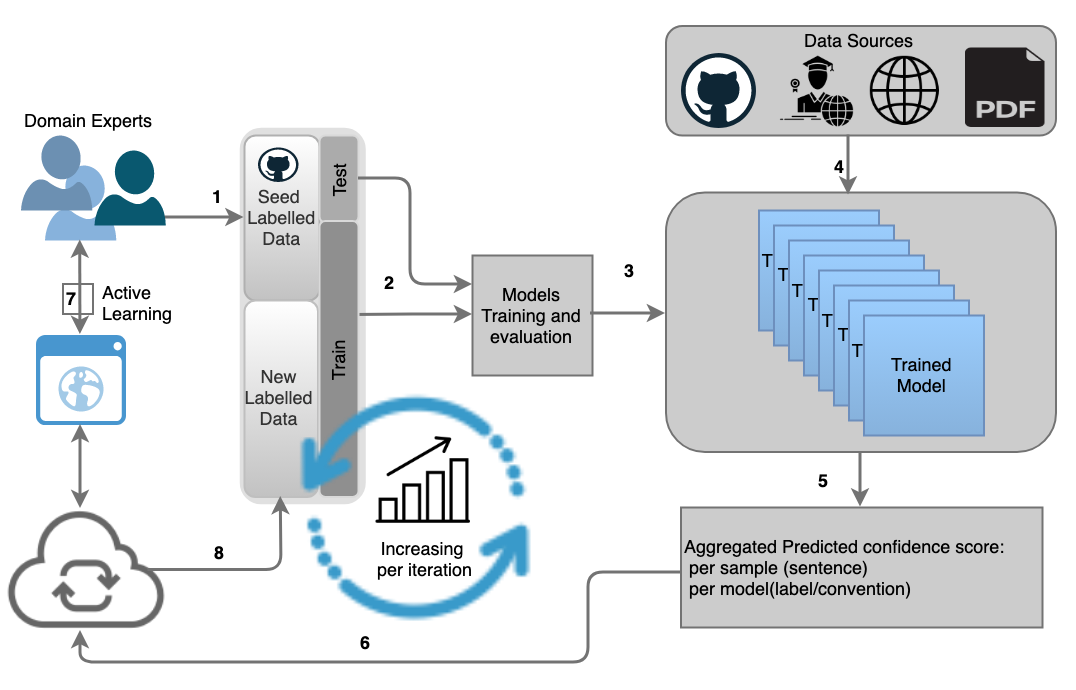

In [69]:
%run "All_helper_classes.ipynb" sort=False
url = 'https://github.com/aideenf/AIVC/raw/master/cp_wssc/Drawings/Active_learning.png'
url2 = 'https://raw.githubusercontent.com/aideenf/AIVC/master/cp_wssc/Data/Iterative-models-building/Gathered_data/Conventions/provenance_count.png'
r = req.get(url)
display (PIL_Img.open(BytesIO(r.content)))

# Start

In [ ]:
%%javascript
//To remove scroll from any output area and automatically extend the jupyter cell
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

# Iterative Model building User interface Class

In [158]:
class Iterative_model:
    def __init__(self, **kwargs):
        
        #Import all helper methods from below notebook#######
        %run "All_helper_classes.ipynb" sort=False
        
        self.parsing_helpers = generic_parsing_helpers()
        #self.aivm_helper = AIVM_helper() create local instance inside methods
        self.model_helpers, self.model_helpers_info = default_model_helpers_for_project()
        self.paths = project_paths()
        self.repo = self.paths.get_repo_data()
        self.path_names = self.paths.get_paths_data()
        print ("Finished importing")
        #######################################################
        
        self.USE_GIT_HUB = True
        
        
        ##Define the various Dataframes that are used during the iterative flow
        self.gathered_conventions_files = [] 
        self.gathered_conventions_df = pd.DataFrame()
        self.conventions_classifications= {} #A dictionary of type pd.DataFrame() one per convention
        
        #series containing only the sentences and only the provenance(from self.conventions_classifications) 
        #self.data_sentences = pd.Series()
        #self.data_sentences_provenance = pd.Series()
        
        #List of path_filenames of the tsv files created from the classification of all gathered data, per classifier
        self.file_list_classified = []
        self.file_list_classified_git = []
    
        
        ##Define the various dictionaries that contain info per model, from pickle files
        self._conventions_models = {}
        self._conventions_tokenizers = {}
        self._conventions_data_val_x = {}
        self._conventions_data_val_y = {}
        self._conventions_train_histories = {}
        
        
    
        ##define the various variables/data sources in the re-train flow 
        ##self.audited_df  = pd.DataFrame()
        self.new_training_data_df  = pd.DataFrame()

       
        #Set up a header accordian to show the c from imported helper files
        self.top_accordion = widgets.Accordion(children=
                              [widgets.HTML(self.model_helpers_info),
                               widgets.HTML(self.repo),
                               widgets.HTML(self.path_names)
                              ])
        
        self.top_accordion.set_title(0, 'Default Model Helper (instance of "model_helpers" helper class)')
        self.top_accordion.set_title(1, 'GIT Hub repo (defined in "paths" helper class)')
        self.top_accordion.set_title(2, 'Project paths (defined in "paths" helper class)')
        self.top_accordion.selected_index = None
        
        #self.something = kwargs['something']
        self.my_style = {'description_width': 'initial'}
        self.my_layout = {'width': '600px'}
        self.my_layout_short = {'width': '300px'}
        self.my_layout_shortest = {'width': '250px'}
        


        self.selectHTMLHead = widgets.HTML(
            "<font color = '#8c8c8c'><h1><center>***  Import 'All_helper_classes.ipynb' and 4 helper classes  ***</center></h1></font>")

            
        self.selectHTMLHeadGit = widgets.HTML(
            "<font color = '#8c8c8c'><h1><center>***  Set GitHub Credentials   ***</center></h1></font>")
        
        self.selectHTMLHeadA = widgets.HTML(
            "<font color = '#8c8c8c'><h1><center>***  Process and Classify gathered data and prepare for Audit  ***</center></h1></font>")

        
        self.selectHTMLHeadB = widgets.HTML(
            "<font color = '#8c8c8c'><h1><center>***  Manually Audit the already classified data  ***</center></h1></font>")
        
        self.selectHTMLHeadC = widgets.HTML(
            "<font color = '#8c8c8c'><h1><center>***  Process the audit output and re-train the models  ***</center></h1></font>")
        
    
        
        html = markdown.markdown("""### 1. Data gathering - Combine all the Gathered Data
            \nThe gathered data has been obtained from various sources. 
            \nFiles must always be in tsv format  "text{tab}provenance" as it is important to keep tracking of where each sentence come from.
            \nFiles beginning with '_' are excluded from consideration.
            \nIdentified data sources:
            \n- Google
            \n- Github
            \n- Semantic Scholar
            \n- pdf files""")

        self.combine_gathered_data_HTML = widgets.HTML(html)
        
        
        html = markdown.markdown("""### 2. Clasification - load the trained classifiers from the pickle files""")
        self.download_model_pickle_HTML = widgets.HTML(html)
        
        
        html = markdown.markdown("""### 3. Pass all of the sentences from the gathered data, through each of the classifiers
                                \nA on completion of this task we will have:
                                \n* conventions_classifications dictionary one entry per model (with score per model per sentence from gathered_data)
                                \n* data_sentences  (list of sentences from gathered_dat)
                                \n* data_sentences_provenance (list of provenance from gathered_data)""") 
        self.classify_gathered_data_HTML = widgets.HTML(html)

        html = markdown.markdown("""### 4. Process the classification results and store them to following location:
                                \npaths.CLASSIFIED_DATA_DIR_LOCAL: ./Data/Iterative-models-building/Classification results/Conventions/
                                \npaths.CLASSIFIED_DATA_DIR_GIT: cp_wssc/Data/Iterative-models-building/Classification results/Conventions/
                                \nStored in Format A (sentence, provenance, convention, score)in eight files of format "results_{convention}_.tsv"
                                \nStored in Format B (sentence, provenance, convention 1 to 8, score 1 to 8) in ONE files of format "classification_results.tsv"
                                \nNOTE: The treshold between class 0 and class 1 is currently set to 0.5 for each model
                                 """)              
        self.store_classified_data_HTML = widgets.HTML(html)
        
        #html = markdown.markdown("""### 5. Process the classification results to the format used by the audit tool""") 
        #self.prepare_data_for_audit_tool_HTML = widgets.HTML(html)
        
        html = markdown.markdown("""### 1. Launch Active Learning Tool: [![Active Learning Tool via Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/aideenf/AIVC/master?filepath=%2Fcp_wssc%2FRun_Audit_Tool.ipynb)""") 
        self.learning_tool_HTML = widgets.HTML(html)  
        
        html = markdown.markdown("""### 1. Aggregate Audited Data for purpose of retraining. 
                                \n The files that have been produced by the audit tool are retrieved and consolodated into a data frame, 
                                this data frame is then converted to tsv file to produce one TSV file with all audited results.

                                \nThis file will be called: 
                                \n'* audited_ALL.tsv'

                                \nA copy will be created with a datestamp should historic data ever be needed:
                                \n'* audited_ALL_{date}-{time}.tsv'

                                \nAny other process that wishes to use this data should read 'audited_ALL.tsv' which is the latest version.""")
        self.aggregate_audited_HTML = widgets.HTML(html)
        
        
        self.space = widgets.Label('  ', layout=widgets.Layout(width='100%'))
        self.small_space = widgets.Label(' ', layout=widgets.Layout(width='5%'))



        self.git_user = widgets.Text(
            description='Username',
            disabled=False,
            layout=self.my_layout_shortest,
            tooltip='Enter your GitHub username',
            style = self.my_style
        )


        self.git_pswd = widgets.Password(
            description='Password',
            disabled=False,
            layout=self.my_layout_shortest,
            tooltip='Enter your GitHub password',
            style = self.my_style
        )


        self.use_git = widgets.Checkbox(
        value=True,
        description='Use GitHub as data source',
        disabled=False
        )
        
        self.convention_drop_down = widgets.Dropdown(
            options={ 
                 'Civic':'convention_civic', 
                 'Domestic':'convention_domestic', 
                 'Green':'convention_green', 
                 'Industrial':'convention_industrial', 
                 'Inspired':'convention_inspired',
                 'Market':'convention_market', 
                 'Project':'convention_project',
                 'Renown':'convention_renown'},
            value='convention_civic',
            description='Convention  :',
            disabled=False,
            style = self.my_style,
            layout = self.my_layout
        )


        self.source_drop_down = widgets.Dropdown(
            options =  {},#convention_sentences_df.data_provenance.unique(),
            description="Data source :",
             #value=None,
            disabled=False,
            style = self.my_style,
            layout = self.my_layout
        )


        self.confidence_score_slider_min = widgets.FloatSlider(
            min=0,#min_confidence, 
            max=1,#max_confidence,
            #value = min_confidence,
            step = 0.1,
            description='Min Confidence level:',
            style = self.my_style,
            layout = self.my_layout
            )
        self.confidence_score_slider_min.style.handle_color = '#5c85d6'
        
        

        self.confidence_score_slider_max = widgets.FloatSlider(
            min=0,#min_confidence, 
            max=1,#max_confidence, 
            #value = max_confidence,
            step = 0.1,
            description='Max Confidence level:',
            style = self.my_style,
            layout = self.my_layout
            )
        self.confidence_score_slider_max.style.handle_color = '#5c85d6'


        self.gathered_data_button = widgets.Button(
                    description='Aggregate Gathered data for classification',
                    disabled=False,
                    button_style='',
                    tooltip='Audit complete, change classification',
                    style = self.my_style,
                    layout = self.my_layout
                )
        self.gathered_data_button.style.button_color = '#3da31e'



        self.get_models_from_pickle_button = widgets.Button(
                    description='Get the Models from pickle' ,
                    disabled=False,
                    button_style='',
                    tooltip='',
                    style = self.my_style,
                    layout = self.my_layout

                )
        self.get_models_from_pickle_button.style.button_color = '#3da31e'


        self.classify_gathered_data_button = widgets.Button(
                    description='Classify Gathered data',
                    disabled=False,
                    button_style='',
                    tooltip='',
                    style = self.my_style,
                    layout = self.my_layout
                )
        self.classify_gathered_data_button.style.button_color = '#3da31e'
        

        self.split_store_classified_data_button = widgets.Button(
                    description='Process the results of the classification',
                    disabled=False,
                    button_style='',
                    tooltip='',
                    style = self.my_style,
                    layout = self.my_layout
                )
        self.split_store_classified_data_button.style.button_color = '#3da31e'
        
#         self.create_file_for_audit_tool_button = widgets.Button(
#                     description='Prepare the classified data for the Audit tool',
#                     disabled=False,
#                     button_style='',
#                     tooltip='',
#                     style = self.my_style,
#                     layout = self.my_layout
#                 )
#         self.split_store_classified_data_button.style.button_color = '#3da31e'
        
        
        self.aggregate_audited_data_button = widgets.Button(
                    description='Aggregate the audited data',
                    disabled=False,
                    button_style='',
                    tooltip='',
                    style = self.my_style,
                    layout = self.my_layout
                )
        self.aggregate_audited_data_button.style.button_color = '#3da31e'
        
        
        self.combine_new_old_training_data_button = widgets.Button(
                    description='Combine original training data with new training data ',
                    disabled=False,
                    button_style='',
                    tooltip='',
                    style = self.my_style,
                    layout = self.my_layout
                )
        self.combine_new_old_training_data_button.style.button_color = '#3da31e'
        

        
        self.progress_gather =  widgets.IntProgress(
                                            value=0,
                                            min=0,
                                            max=10,
                                            step=1,
                                            description='Processing gathered data:',
                                            bar_style='', # 'success', 'info', 'warning', 'danger' or ''
                                            orientation='horizontal')
            
        self.progress_download =  widgets.IntProgress(
                                            value=0,
                                            min=0,
                                            max=10,
                                            step=1,
                                            description='Downloading Models from pickle:',
                                            bar_style='', # 'success', 'info', 'warning', 'danger' or ''
                                            orientation='horizontal')
        
        self.progress_classify =  widgets.IntProgress(
                                            value=0,
                                            min=0,
                                            max=10,
                                            step=1,
                                            description='Classifying sentences per model:',
                                            bar_style='', # 'success', 'info', 'warning', 'danger' or ''
                                            orientation='horizontal')
        
        self.progress_split_store =  widgets.IntProgress(
                                            value=0,
                                            min=0,
                                            max=10,
                                            step=1,
                                            description='Storing classify results per model:',
                                            bar_style='', # 'success', 'info', 'warning', 'danger' or ''
                                            orientation='horizontal' )
        
        
        
                
        self.progress_create_file_for_audit =  widgets.IntProgress(
                                            value=0,
                                            min=0,
                                            max=10,
                                            step=1,
                                            description='Creating file for Audit tool:',
                                            bar_style='', # 'success', 'info', 'warning', 'danger' or ''
                                            orientation='horizontal' )

        self.save_model_to_git_button = widgets.Button(
                description='Save new pickled model to GitHub',
                disabled=False,
                button_style='',
                tooltip='Click me',
                style = self.my_style,
                layout = self.my_layout,
            )
        self.save_model_to_git_button.style.button_color = '#3da31e'

        self.main_output = widgets.interactive_output(self.output_function, {
                'convention_drop_down_value': self.convention_drop_down,
                'confidence_score_slider_min_value': self.confidence_score_slider_min,
                'confidence_score_slider_max_value': self.confidence_score_slider_max,
                'source_drop_down_value': self.source_drop_down,
                })
        
        
        self.github_output = widgets.interactive_output(self.github_function, {
            'git_user_value': self.git_user,
            'git_pswd_value': self.git_pswd,
            'use_git_value' : self.use_git
            })

        self.outputStep1 = widgets.Output()
        self.outputStep2 = widgets.Output()
        self.outputStep3 = widgets.Output()
        self.outputStep4 = widgets.Output()
        self.outputStep5 = widgets.Output()
        self.outputStep6 = widgets.Output()
        self.outputStep7 = widgets.Output()

        self.gathered_data_button.on_click(self.gathered_data_button_clicked)
        self.get_models_from_pickle_button.on_click(self.get_models_from_pickle_button_clicked)
        self.classify_gathered_data_button.on_click(self.classify_gathered_data_button_clicked)
        self.split_store_classified_data_button.on_click(self.split_store_classified_data_button_clicked)
        #self.create_file_for_audit_tool_button.on_click(self.create_file_for_audit_tool_button_clicked)
        self.aggregate_audited_data_button.on_click(self.aggregate_audited_data_button_clicked)
        self.combine_new_old_training_data_button.on_click(self.combine_new_old_training_data_button_clicked)

    
    
    # Call the helper methods to read from directory and aggregate all gathered data files
    def gathered_data_button_clicked(self, b):
        aivm_helper = AIVM_helper()
        with self.outputStep1:
            clear_output(wait=True)
            self.progress_gather.value = 2
            if (self.USE_GIT_HUB == True):
                print ("Gathering data directly from from GitHub :", self.paths.GATHERED_DATA_CONV_DIR_GIT)
            # Read the gathered_data files "paths.TRAINING_DATA_DIR_FILE" with column_to_clean = 'text' and return 
            # a pandas Data Frame
            
            self.gathered_conventions_files, self.gathered_conventions_df = self.model_helpers.get_aggregated_gathered_data (
                            self.USE_GIT_HUB,
                            self.paths.GATHERED_DATA_CONV_DIR_GIT,
                            self.paths.GATHERED_DATA_CONV_DIR_LOCAL,
                            self.paths.GITHUB_GATHERED_URL_PATH, 
                            self.paths.GIT_OWNER,
                            self.paths.GIT_REPO)
            self.progress_gather.value = 8
            display ("Now we have a dictionary(self.gathered_conventions_data) of files one entry for each gathered sentence source:" , self.gathered_conventions_files)
            print("")
            display ("Now we have a pandas DataFrame containing the files aggregated content")
            display (self.gathered_conventions_df.head(5))
            print("")
            print ("Number of sentences in gathered data: ",self.gathered_conventions_df.shape[0])
            print ("remove any sentences already in training data")
            
            all_training_data_df = self.model_helpers.retrieve_tsv_data_from_git (self.paths.TRAINING_DATA_ALL_MULTI_DIR_FILE_GIT)
            display (all_training_data_df.head())
            print ("Number of sentences in trainig data: ",all_training_data_df.shape[0])
             print ("TODO - Remive any sentences from gathered that are already audited ie already in training data")
            
            #HERE
#             test = pd.merge(self.gathered_conventions_df ,
#                      all_training_data_df, 
#                      indicator=True, 
#                      how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
            
            #self.gathered_conventions_df - all_training_data_df
            print ("Number of sentences in test: ",test.shape[0])
            cross_tab_gathered = pd.crosstab(self.gathered_conventions_df['provenance'],self.gathered_conventions_df['provenance'].count())
            plot = cross_tab_gathered.plot(kind='bar', figsize=(8, 8), title ="Gathered Data Provenance count")
            
            
            fig = aivm_helper.save_plot(plot, 
               "provenance_count.png", 
               self.paths.GATHERED_DATA_CONV_DIR_LOCAL, 
               self.paths.GATHERED_DATA_CONV_DIR_GIT, 
               self.USE_GIT_HUB, 
               self.git_user.value, 
               self.git_pswd.value, 
               self.paths.GIT_OWNER_REPO)
            self.progress_gather.value = 10
            display(fig)
            plt.clf() #To release the fig from memory
            plt.close(fig) #To release the fig from memory
            gc.collect()

     # Call the helper methods to extract the trained models from the pickle files they are stored to   
    def get_models_from_pickle_button_clicked(self,b):
        with self.outputStep2:
            clear_output(wait=True)
            self.progress_download.value = 2
            print ("Reading Trained model from pickle:")
            ## Read pickled classifiers https://www.thoughtco.com/using-pickle-to-save-objects-2813661
            # Note: pickle is used for serializing and de-serializing a Python object structure. 
            # Any object in python can be pickled so that it can be saved on disk. 
            # What pickle does is that it “serialises” the object first before writing it to file. 
            # Pickling is a way to convert a python object (list, dict, etc.) into a character stream
            ## read convention models from pickle file from gitHub or local  (NOTE: this is in GIT)
        
            if(self.USE_GIT_HUB == True): 
     
                #make sure updated pickle files are in github
                self._conventions_models, self._conventions_tokenizers, self._conventions_data_val_x ,self._conventions_data_val_y ,self._conventions_train_histories = self.model_helpers.read_DL_models_from_pickle(True, self.paths.CONV_MODEL_PCKL_URL, self.paths.MODELS_DIR_LOCAL)
   
    
            elif(self.USE_GIT_HUB == False):
                ## Load the  convention models from the downloaded pickle file
                self._conventions_models, self._conventions_tokenizers, self._conventions_data_val_x ,self._conventions_data_val_y ,self._conventions_train_histories = self.model_helpers.read_DL_models_from_pickle(False, 'conv_models_items.pickle', self.paths.MODELS_DIR_LOCAL)
            self.progress_download.value = 8
            self.progress_download.value = 10
            display("Models loaded from the pickle file, one per convention", self._conventions_models)
            gc.collect()
            
            
    def classify_gathered_data_button_clicked(self, b):
        with self.outputStep3:
            clear_output(wait=True)
            print ("Classifying all gathered data:")
            data_sentences = self.gathered_conventions_df['text']
            self.progress_classify.value = 4
            self.progress_classify.value = 5
            self.conventions_classifications = self.model_helpers.calculate_matches_DL(data_sentences, self._conventions_models, self._conventions_tokenizers)
            print ("All gathered data classified:")
            self.progress_classify.value = 10
            
            #A dictionary of numpty arrays, one per convention containing classification results per sentence (per convention)
            print ("A dictionary of numpty arrays, one entry per convention containing classification results per sentence per convention")
            print("")
            for conv in self.conventions_classifications:
                print (conv)
                print (self.conventions_classifications[conv])
                print("")
            gc.collect()
            

    def split_store_classified_data_button_clicked(self, b): 
        with self.outputStep4:
            clear_output(wait=True)
           
            self.progress_split_store.value = 1
            data_sentences = self.gathered_conventions_df['text']
            data_sentences_provenance = self.gathered_conventions_df['provenance']
            
            self.file_list_classified, self.file_list_classified_git = self.create_classified_files (self.conventions_classifications, 
                                                                                                 data_sentences, 
                                                                                                 data_sentences_provenance,
                                                                                                 self.paths.CLASSIFIED_DATA_DIR_LOCAL,
                                                                                                 self.paths.CLASSIFIED_DATA_DIR_GIT)
            self.progress_split_store.value = 5
            
            single_classification_results_file, single_classification_results_file_git =  self.create_single_classification_results_file (self.conventions_classifications, 
                                                     data_sentences, 
                                                     data_sentences_provenance,
                                                     self.paths.CLASSIFIED_DATA_DIR_LOCAL,
                                                     self.paths.CLASSIFIED_DATA_DIR_GIT)
            
            self.progress_split_store.value = 7
            self.file_list_classified.append(single_classification_results_file[0])
            self.file_list_classified_git.append (single_classification_results_file_git[0])
            print ("The following files have been created locally")
            display (self.file_list_classified)

            
            if (self.USE_GIT_HUB == True):
                print ("Now pushing files to GitHub...")
                self.save_results_to_git(self.file_list_classified, self.file_list_classified_git, self.git_user.value, self.git_pswd.value, self.paths.GIT_OWNER_REPO)
                print ("Finished saving classification results to GitHub")
                self.progress_split_store.value = 8
                self.progress_split_store.value = 10
            gc.collect()

            
    #Create the aggregated dataframe of the classified "Gathered_data" 
    #to then used by the audit tool to obtain more training data         
#     def create_file_for_audit_tool_button_clicked(self, b):
#         with self.outputStep5:
#             clear_output(wait=True)
#             self.progress_create_file_for_audit.value = 1
#             self.progress_create_file_for_audit.value = 4
#             self.create_audit_file_in_git(self.file_list_classified, 
#                                      self.git_user.value,
#                                      self.git_pswd.value, 
#                                      self.paths.GIT_OWNER_REPO, 
#                                      self.paths.CLASSIFIED_DATA_DIR_LOCAL, 
#                                      self.paths.CLASSIFIED_DATA_DIR_GIT )
#             self.progress_create_file_for_audit.value = 10
#             #NOTE: Here we should make sure that any sentences already audited are not included again.
#             #Audit tool data = gathered data - any duplicates with Training data.
#             print ("Finished creating consolidated file for the audit tool")
#             self.free_memory()
    
    
    def aggregate_audited_data_button_clicked(self, b):
        with self.outputStep6:
            clear_output(wait=True)
            #Call the aggregate_audited_data method to have the aggregated data regenerated and a pandas data frame returned.
            audited_df, message = self.model_helpers.aggregate_audited_data_from_git (self.paths.AUDITED_DATA_DIR_GIT,
                            self.paths.GITHUB_AUDIT_URL_PATH, 
                            self.paths.AUDITED_DATA_DIR_LOCAL,
                            self.git_user.value, 
                            self.git_pswd.value, 
                            self.paths.GIT_OWNER_REPO,
                            self.paths.GIT_OWNER,
                            self.paths.GIT_REPO)

            display (audited_df.head(5))
            print (message)
            print ("The number of audited samples are", audited_df.shape[0])

    def co_occurance_matrix (self, df_class_only):
            convention_list = []
            for col in df_class_only.columns: 
                convention_list.append(col) 
            df_class_only = df_class_only.astype(float)
            co_occ = df_class_only.T.dot(df_class_only)
            print("")
            print("")
            display (HTML("<b>***Co-Occurance matrix not normalised***</b>"))
            display(co_occ)
            #normalise using Jaccard similarity, ie 
            #for co-occurance of 'green and industrial' divide by sum of 'green or industrial' 
            #and divide each entry in the matrix by it). 
            #this should result in symmetric matrix. 
            ##############################################
            for row in convention_list:
                for column in convention_list:
                    if row != column:
                    #print("new value", co_occ.at[row,column]/(co_occ.at[row,row] + co_occ.at[column,column]))
                        co_occ.at[row,column] = co_occ.at[row,column]/(co_occ.at[row,row] + co_occ.at[column,column])
            for row in convention_list:
                for column in convention_list:
                    if row == column:
                        co_occ.at[row,column] = 1
            ###############################################        
            print("")
            print("")
            display (HTML("<b>***Co-occurance matrix normalised using Jaccard similarity***</b>"))
            display(co_occ)
            sns.heatmap(co_occ, annot=True,vmin=0, vmax=1, center=0.7)
            plt.show()
            gc.collect()
            
            
        
    def combine_new_old_training_data_button_clicked(self, b):
        aivm_helper = AIVM_helper()
        convention_list = ['civic','domestic','green','industrial','inspired','market','project','renown']
        with self.outputStep7:
            clear_output(wait=True)
            # Read the already static training data file "paths.TRAINING_DATA_DIR_FILE" with column_to_clean = 'text' and return 
            # a pandas Data Frame of training data
            training_df = self.model_helpers.get_training_data(
                            self.USE_GIT_HUB,
                            self.paths.TRAINING_DATA_DIR_FILE_GIT,
                            self.paths.TRAINING_DATA_DIR_FILE_LOCAL, 
                            self.paths.GIT_OWNER,
                            self.paths.GIT_REPO)
            

            
            #Get the latest version of the aggregated already audited data (output from the audit tool) directly from GIT
            audited_data_df = self.model_helpers.retrieve_aggregate_audited_data_from_git (self.paths.GITHUB_AGGREGATED_AUDIT_URL_FILE)
            audited_data_raw_df = self.model_helpers.retrieve_tsv_data_from_git (self.paths.GITHUB_AGGREGATED_AUDIT_URL_FILE)
            print("")
            display (HTML("<font color = green><h3><left>*** AUDITED DATA  ***</left></h3></font>"))
            print ("Audit results with all columns:")
            display (audited_data_raw_df.head(2))
            print("")
            #print ("Audit results processed to combine with original Training data:")
            #display (audited_data_df.head(2))
#            print("")
#            print ("Audit Statistics")
#            test =  audited_data_raw_df[['convention', 'new', 'old']].copy()
#            test[(test['new']==1) & (test['old']==1)].groupby('convention').count().plot(kind='bar', title="True Positive")  
#            test[(test['new']==0) & (test['old']==0)].groupby('convention').count().plot(kind='bar', title="True Negative") 
#            test[(test['new']==0) & (test['old']==1)].groupby('convention').count().plot(kind='bar', title="False Positive")  
#            test[(test['new']==1) & (test['old']==0)].groupby('convention').count().plot(kind='bar', title="False Negative")
#            plt.show();
#            plt.close();
#            plt.clf();
            
            audited_data_df = self.convert_to_multi_label_format(audited_data_df)
            # get the co-occurance matrix for the convention columns
            df_class_only = audited_data_df[convention_list]
            
            self.co_occurance_matrix (df_class_only)
            
            # graph the stats
            display(df_class_only.apply(pd.Series.value_counts).iloc[1])
            df_class_only.apply(pd.Series.value_counts).iloc[1].plot(kind='bar', figsize=(8, 8), title ="Audit Data: Label 1")
            plt.show();
            plt.close();
            plt.clf();
            print("")
            display (HTML("<font color = green><h3><left>*** ORIGINAL TRAINING DATA  ***</left></h3></font>"))
            display (training_df.head(2))

            # get the co-occurance matrix for the convention columns of original training data
            df_class_only = training_df[convention_list]
            self.co_occurance_matrix(df_class_only)
            
            # graph the stats
            display(df_class_only.apply(pd.Series.value_counts).iloc[1])
            df_class_only.apply(pd.Series.value_counts).iloc[1].plot(kind='bar', figsize=(8, 8), title ="Original Training Data: Label 1")
            plt.show();
            plt.close();
            plt.clf();


            display (HTML("<font color = green><h3><left>*** NEW TRAINING DATA  ***</left></h3></font>"))     
            print ("Combined 'Class 1' for Original Training data and audited data :")

            
            #Create a consolidated new Training_data with the Audited and original training data merged, 
            self.new_training_data_df =  pd.concat([training_df, audited_data_df], sort=False, ignore_index=True)
            display(self.new_training_data_df.head(5) )
            self.new_training_data_df = self.new_training_data_df.reset_index(drop=True)
            print ("") 
            print ("Calling a method to balance the data for an equal amount of Class 1 and 0:")
            print ("") 
            
            
            self.new_training_data_df, cross_tab_after = self.model_helpers.create_label_balance (self.new_training_data_df,
                                                                self.paths.TRAINING_DATA_DIR_LOCAL,
                                                                self.paths.TRAINING_DATA_DIR_GIT,
                                                                self.git_user.value, 
                                                                self.git_pswd.value,
                                                                self.paths.GIT_OWNER_REPO,
                                                                self.USE_GIT_HUB)
            plt.clf()  
            plot = cross_tab_after.plot(kind='bar', figsize=(8, 8), title ="New training data")
            plt.show();
            fig = aivm_helper.save_plot(plot,
                                        "convention_training_data_proportions.png", 
                                        self.paths.TRAINING_DATA_DIR_LOCAL, 
                                        self.paths.TRAINING_DATA_DIR_GIT, 
                                        self.USE_GIT_HUB, 
                                        self.git_user.value, 
                                        self.git_pswd.value, 
                                        self.paths.GIT_OWNER_REPO)
                         
            plt.clf() #To release the fig from memory
            plt.close(fig)#To release the fig from memory
            gc.collect()
            
    
    def output_function(self, convention_drop_down_value, confidence_score_slider_min_value, confidence_score_slider_max_value, source_drop_down_value ):
        print ("Output function:")
    
    
    def github_function(self, git_user_value, git_pswd_value, use_git_value ):
        print ("User name:",git_user_value)
        print ("Password:",git_pswd_value)
        self.USE_GIT_HUB = use_git_value
        print ("Use GitHub:",self.USE_GIT_HUB)


    #conventions_classifications exists per convention and contains the probability that the sentence was classified as 1
    #for each model for each sentence. *****COULD MOVE TO HELPER FILE*****
    def create_classified_files (self, conventions_classifications, data_sentences, data_sentences_provenance, dir_local, dir_git):
        file_list = []
        file_list_git = []
        for k in conventions_classifications.keys():
            file_name = k.replace("training_", "")
            file_name = file_name.replace(".txt", "")
            # if we do not want the "training in the name" k.replace("training_", "").lower()
            with open(os.path.join(dir_local, "results_{}.tsv".format(file_name)), "w")as f3:
        
                file_list.append(dir_local + "results_{}.tsv".format(file_name))
                file_list_git.append(dir_git + "results_{}.tsv".format(file_name))
        
                f3.write("{}\t{}\t{}\t{}\n".format("text", "convention", "confidence_value", "data_provenance"))
    
                for cc, ds, dsp in zip(conventions_classifications[k], data_sentences, data_sentences_provenance ):
                    convention = k.replace("training_", "").lower() 
                    convention = convention.replace(".txt", "").lower() 

                    f3.write("{}\t{}\t{}\t{}\n".format(ds, convention, cc, dsp))
                f3.close()
        gc.collect()
        return file_list, file_list_git
    
     #conventions_classifications exists per convention and contains the probability that the sentence was classified as 1
    #for each model for each sentence. *****COULD MOVE TO HELPER FILE*****
    def create_single_classification_results_file (self, conventions_classifications, data_sentences, data_sentences_provenance, dir_local, dir_git):
        # There is one conventions classification 
        # Entering this method we have:
        # conventions_classifications dictionary one entry per model (with score per model per sentence from gathered_data)
        # data_sentences (list of sentences from gathered_dat)
        # data_sentences_provenance (list of provenance from gathered_data)
        
        # For now assuming the thresholds are all 0.5 (how do we decide this?)
        thresholds = {
                        "domestic" : 0.5,
                        "civic" : 0.5,
                        "project" : 0.5,
                        "inspired" : 0.5,
                        "green" : 0.5,
                        "market" : 0.5,
                        "industrial" : 0.5,
                        "renown" : 0.5
        }
        
        file_list = []
        file_list_git = []
        current_keys = []
        new_keys = []
        file_name = "classification_results.tsv"

        print ("Number of sentences to process ", len(data_sentences))

        # Rename the dictionary keys as the convention name in lower case
        for k in conventions_classifications.keys():           
            current_keys.append(k)       
        for k in current_keys:
            convention = k.replace("training_", "").replace(".txt", "").lower()
            conventions_classifications[convention] = conventions_classifications.pop(k)
            new_keys.append(convention) 
        #dictionary keys are renamed
        
        
        first_line = "text\tdata_provenance\t"
        
        for c in conventions_classifications.keys():
            first_line = first_line + c + "_score" + '\t' + c + '\t' 
        first_line = first_line.rstrip('\t') + '\n'
          
        with open(os.path.join(dir_local, file_name), "w")as f3:
            f3.write (first_line)
            for s, p, index in zip(data_sentences, data_sentences_provenance, range(len(data_sentences))):
                new_line = "{}\t{}\t".format(s, p)
                for k in conventions_classifications.keys():
                    score = conventions_classifications[k][index]
                    label_class = 0
                    if (score >= thresholds[k]):
                        label_class = 1
                    new_line =  new_line +  str(score) + '\t' +  str(label_class) + '\t'
                new_line = new_line.rstrip('\t') + '\n'
                f3.write(new_line)

        f3.close()
        df = pd.read_csv(dir_local + file_name, sep='\t')
        print ("Note: The treshold for each model: ", thresholds)
        print ("Number of Data Frame records produced is: ", df.shape[0])
        display (df.head(5))
        file_list.append(dir_local + file_name)
        file_list_git.append(dir_git + file_name)  
        
        # conver to co-occurance matrix
        df_class_only = df[new_keys]
        df_class_only = df_class_only.astype(float)
        co_occ = df_class_only.T.dot(df_class_only)
        
        print("")
        print("")
        display (HTML("<b>***Co-occurance matrix not normalised***</b>"))
        display(co_occ)
   
        #normalise using Jaccard similarity, ie 
        #for co-occurance of 'green and industrial' divide by sum of 'green or industrial' 
        #and divide each entry in the matrix by it). 
        #this should result in symmetric matrix. 
        ##############################################
        for row in new_keys:
            for column in new_keys:
                if row != column:
                    #print("new value", co_occ.at[row,column]/(co_occ.at[row,row] + co_occ.at[column,column]))
                    co_occ.at[row,column] = co_occ.at[row,column]/(co_occ.at[row,row] + co_occ.at[column,column])
        for row in new_keys:
            for column in new_keys:
                if row == column:
                    co_occ.at[row,column] = 1
        ###############################################
        
        print("")
        print("")
        display (HTML("<b>***Co-occurance matrix normalised using Jaccard similarity***</b>"))
        display(co_occ)
        sns.heatmap(co_occ, annot=True,vmin=0, vmax=1, center=0.7)
        plt.show()
        gc.collect()
        
        return file_list, file_list_git
    
    def convert_to_multi_label_format (self, data_frame):
        aivm = AIVM_helper()
        df = data_frame
        df['text'] = df['text'].str.strip()
        df['text'] = df['text'].apply(aivm.pre_process_sentence)
        ##numbers should be equal if there are no duplicates
        print ("Number of unique strings", len(df['text'].unique()))
        print ("Length of data frame", len(df.index))
        
        duplicateRowsDF = df[df.duplicated(['text'])]
        print("Number of dupes =", duplicateRowsDF.shape[0])

         ## We will perform one hot encoding
        df["convention"] = pd.Categorical(df["convention"])
        dfDummies = pd.get_dummies(df["convention"], prefix="convention")
        my_list = []
        for col in dfDummies.columns: 
            my_list.append(col) 
        df = pd.concat([df, dfDummies], axis=1)

        for col in my_list:
             df.loc[(df.label == 0) & (df[col] == 1), col] = 0   

        df = df.drop(["convention"], axis=1)
        df = df.drop(["label"], axis=1)
        temp_list = []
        for col in my_list:
            df.rename(columns={col:col.replace('convention_', "").lower()}, inplace=True)
            temp_list.append(col.replace('convention_', "").lower())
        my_list = temp_list   

        print ("Merging duplicate rows")
        df = df.groupby(['text','provenance'], as_index=False)[my_list].sum()
        print ("Number of unique strings after merge ", len(df['text'].unique()))
        print ("Length of data frame after merge", len(df.index))
        df = df.replace (2, 1)
        df = df.replace (3, 1)
        df = df.dropna()
        print ("Length of data frame after drop NaN", len(df.index))
        #duplicateRowsDF = df[df.duplicated(['text'],keep="last")]
        #print("Number of dupes =", duplicateRowsDF.shape[0])
        return df
 
       
    def save_results_to_git(self, file_list_classified, file_list_classified_git, git_user, git_pswd, git_owner_repo):
    
        #push to github
        my_file_list = file_list_classified
        push_to_git_as = file_list_classified_git
        aivm_helper = AIVM_helper()
        
        commit, message = aivm_helper.save_to_github(git_user, git_pswd, git_owner_repo, my_file_list, push_to_git_as, "auto push classified conventions")

        if (commit != "error"):
            display("File to commit:", my_file_list)
            display ("Push to git as:", push_to_git_as)
            print ("Commit: ", commit)
            display(HTML("<font color='green'><b>Files Saved!!</b></font>"))
        
            
        if (commit == "error"):
            display ("File to commit: ", my_file_list)
            display ("Push to git as: ", push_to_git_as)
            display(HTML("<font color='red'><b>Warning!!</b></font>"))
            print(message)
            
        return file_list_classified

    
    #Create an aggregated DataFrame and then a tsv/csv file of the full data for auditing
    #This code is to create a file and push it to git hub to be read by the audit tool only
    def create_audit_file_in_git(self, file_list_classified, 
                                 git_user, 
                                 git_pswd, 
                                 git_owner_repo, 
                                 classified_dir_local, 
                                 classified_dir_git ):
        
        aivm_helper = AIVM_helper()
        file_list = file_list_classified
        df_list = [pd.read_csv(file, sep='\t') for file in file_list]
        #concatenate them 
        print("Concatenate all files to one")
        convention_sentences_df = pd.concat(df_list)
        convention_sentences_df.reset_index()
        ## We will perform one hot encoding
        print("Applying one hot encoding to convention to have format suitable for audit tool (binary and for all)")
        convention_sentences_df["convention"] = pd.Categorical(convention_sentences_df["convention"])
        dfDummies = pd.get_dummies(convention_sentences_df["convention"], prefix="convention")
        convention_sentences_df = pd.concat([convention_sentences_df, dfDummies], axis=1)
        convention_sentences_df = convention_sentences_df.drop(["convention"], axis=1)

        ## Now we will save a file 'audit_training_data.tsv'  and zipped version locally which contains all of the results
        file_name = 'audit_training_data.tsv'
        file_name_zip = 'audit_training_data.gz'

        convention_sentences_df.to_csv(classified_dir_local + file_name)
        convention_sentences_df.to_csv(classified_dir_local + file_name_zip, compression='gzip')

        ## We will also push this to git hub for use by audit tool
        if(self.USE_GIT_HUB == True):
            #Call helper file to zip the file for push to github
            my_file_list = [classified_dir_local + file_name_zip]
            push_to_git_as = [classified_dir_git + file_name_zip]

            commit, message = aivm_helper.save_to_github(git_user, git_pswd, git_owner_repo, my_file_list, push_to_git_as, "auto push for audit")

            if (commit != "error"):
                print ("File to commit:", my_file_list)
                print ("Push to git as:", push_to_git_as)
                print ("Commit: ", commit)
                display(HTML("<font color='green'><b>Files Merged and Saved!!</b></font>"))
        
            
            if (commit == "error"):
                print ("File to commit: ", my_file_list[0])
                print ("Push to git as: ", push_to_git_as[0])
                display(HTML("<font color='red'><b>Warning!!</b></font>"))
                print(message)

                
    

    def free_memory (self):
        self.gathered_conventions_files = [] 
        self.gathered_conventions_df = pd.DataFrame()
        self.conventions_classifications= {} #A dictionary of type pd.DataFrame() one per convention
        self.file_list_classified = []
        self.file_list_classified_git = []
        self._conventions_models = {}
        self._conventions_tokenizers = {}
        self._conventions_data_val_x = {}
        self._conventions_data_val_y = {}
        self._conventions_train_histories = {}
        gc.collect()
        
 
    


    def show(self):
        display (
                self.selectHTMLHead,
                self.top_accordion,
                self.selectHTMLHeadGit,
                self.git_user,
                self.git_pswd,
                self.use_git,
                self.github_output,
                self.selectHTMLHeadA,
                self.combine_gathered_data_HTML,
                self.gathered_data_button,
                self.progress_gather,
                self.outputStep1,
                self.space,
                self.download_model_pickle_HTML,
                self.get_models_from_pickle_button,
                self.progress_download,
                self.outputStep2,
                self.space,
                self.classify_gathered_data_HTML,
                self.classify_gathered_data_button,
                self.progress_classify,
                self.outputStep3,
                self.store_classified_data_HTML,
                self.split_store_classified_data_button,
                self.progress_split_store,
                self.outputStep4,
#                 self.prepare_data_for_audit_tool_HTML,
#                 self.create_file_for_audit_tool_button,
#                 self.progress_create_file_for_audit,
#                 self.outputStep5,
                self.space,
                self.space,
                self.space,
                self.selectHTMLHeadB,
                self.learning_tool_HTML,
                self.space,
                self.space,
                self.space,
                self.selectHTMLHeadC,
                self.space, 
                self.aggregate_audited_HTML,
                self.aggregate_audited_data_button,
                self.outputStep6,
                self.combine_new_old_training_data_button,
                self.outputStep7
            )


In [159]:
im = Iterative_model()
im.show()

Necessary libraries imported.
Initialised generic_parsing_helpers class and methods
Initialised model_helpers class and methods
Finished importing


HTML(value="<font color = '#8c8c8c'><h1><center>***  Import 'All_helper_classes.ipynb' and 4 helper classes  *…

Accordion(children=(HTML(value='You will find instantiate_model_helpers_for_project at the very TOP of All_hel…

HTML(value="<font color = '#8c8c8c'><h1><center>***  Set GitHub Credentials   ***</center></h1></font>")

Text(value='', description='Username', layout=Layout(width='250px'), style=DescriptionStyle(description_width=…

Password(description='Password', layout=Layout(width='250px'), style=DescriptionStyle(description_width='initi…

Checkbox(value=True, description='Use GitHub as data source')

Output()

HTML(value="<font color = '#8c8c8c'><h1><center>***  Process and Classify gathered data and prepare for Audit …

HTML(value='<h3>1. Data gathering - Combine all the Gathered Data</h3>\n<p>The gathered data has been obtained…

Button(description='Aggregate Gathered data for classification', layout=Layout(width='600px'), style=ButtonSty…

IntProgress(value=0, description='Processing gathered data:', max=10)

Output()

Label(value='  ', layout=Layout(width='100%'))

HTML(value='<h3>2. Clasification - load the trained classifiers from the pickle files</h3>')

Button(description='Get the Models from pickle', layout=Layout(width='600px'), style=ButtonStyle(button_color=…

IntProgress(value=0, description='Downloading Models from pickle:', max=10)

Output()

Label(value='  ', layout=Layout(width='100%'))

HTML(value='<h3>3. Pass all of the sentences from the gathered data, through each of the classifiers</h3>\n<p>…

Button(description='Classify Gathered data', layout=Layout(width='600px'), style=ButtonStyle(button_color='#3d…

IntProgress(value=0, description='Classifying sentences per model:', max=10)

Output()

HTML(value='<h3>4. Process the classification results and store them to following location:</h3>\n<p>paths.CLA…

Button(description='Process the results of the classification', layout=Layout(width='600px'), style=ButtonStyl…

IntProgress(value=0, description='Storing classify results per model:', max=10)

Output()

Label(value='  ', layout=Layout(width='100%'))

Label(value='  ', layout=Layout(width='100%'))

Label(value='  ', layout=Layout(width='100%'))

HTML(value="<font color = '#8c8c8c'><h1><center>***  Manually Audit the already classified data  ***</center><…

HTML(value='<h3>1. Launch Active Learning Tool: <a href="https://mybinder.org/v2/gh/aideenf/AIVC/master?filepa…

Label(value='  ', layout=Layout(width='100%'))

Label(value='  ', layout=Layout(width='100%'))

Label(value='  ', layout=Layout(width='100%'))

HTML(value="<font color = '#8c8c8c'><h1><center>***  Process the audit output and re-train the models  ***</ce…

Label(value='  ', layout=Layout(width='100%'))

HTML(value="<h3>1. Aggregate Audited Data for purpose of retraining.</h3>\n<p>The files that have been produce…

Button(description='Aggregate the audited data', layout=Layout(width='600px'), style=ButtonStyle(button_color=…

Output()

Button(description='Combine original training data with new training data ', layout=Layout(width='600px'), sty…

Output()

Initialised AIVM_helper class and methods


In [ ]:
Graph the label co-occurence in the training data
Graph the label co-occurence in the gathered/classified data (where treshold = 0.5 for all)

"hamming loss (which ignores label correlations) is a good measure of generalization quality, 
maybe jaccard or 0-1 accuracy are better. What does it mean for your problem to miss a label 
out of a set of labels? Is it more importand to recall relevant documents or maybe it's 
important to have a high precision. Is a proportion of properly assigned labels to all 
assigned important? What is the cost of making a mistake in your classification in real life? 
Which cost is the highest, it will be different in classifying patients with syndromes in 
medicine and in classification journalism texts for publishing."

In [ ]:
To Discuss
https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/
Platt Scaling is simpler and is suitable for reliability diagrams with the S-shape. 
Isotonic Regression is more complex, requires a lot more data (otherwise it may overfit),
but can support reliability diagrams with different shapes (is non-parametric).

These plots are commonly referred to as ‘reliability‘ diagrams in forecast literature, although may 
also be called ‘calibration‘ plots or curves as they summarize how well the forecast probabilities 
are calibrated.

http://dmip.webs.upv.es/LMCE2014/Papers/lmce2014_submission_11.pdf
The threshold can be adjusted in many different ways: label-wise, 
instancewise or globally (one threshold). Moreover, most of the multi-label 
classifiers are metaclassifiers using a single-label classifier as a base classifier.
In some thresholding methods, it is important to predict well-calibrated probabilities, as we will see later.


NOTE: Advantage of one vs All 
"Advantage of this approach is its interpretability. 
Since each class is represented by one and only one classifier, 
it is possible to gain knowledge about the class by inspecting its corresponding classifier"


http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.130.7318&rep=rep1&type=pdf

LSTM and/or chain classifiers
https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff
    

# END
code below here is no longer used, however keeping it for reference.

# Retrain the models

In [ ]:
 ## Train DL models

    _DLModels, _DLTokenizers, _DLData_val_x, _DLData_val_y, _DLTrain_histories = model_helpers.train_DL_models
                    (new_training_data_df,
                    data_class_column="convention", 
                    data_label_column="label",
                    tokenizer=extended_tokenizer,
                    random_seed=0,
                    use_validation=False) 

    ## Train ML models
    _MLModels = model_helpers.train_ML_models(new_training_data_df) 

    ##Getting sentences from data
    test_sentences = new_training_data_df['text'].values

    ## Calculate probability scores for for text data combining DL predictions and ML predictions
    mixture_preds = model_helpers.calculate_matches_mixture(test_sentences, _MLModels, _DLModels, _DLTokenizers)

    ## Getting top sentences per convention
    for conv in _MLModels.keys():
        print("\n\n     {}    \n\n".format(conv))
        for s in test_sentences[mixture_preds[conv].argsort()[-NUM_SENTENCES_TO_SHOW:][::-1]]:
            print("{}\n".format(test_sentences[s]))
            
            
    ## Store DL models in a pickle file
    model_helpers.store_DL_models_in_picke("test.pickle", _DLModels, _DLTokenizers, _DLData_val_x, _DLData_val_y, _DLTrain_histories, paths.PICKLED_MODELS_DIR)
    
    ## Read DL models from a pickle file
    _DLModels, _DLTokenizers, _DLData_val_x, _DLData_val_y, _DLTrain_histories = model_helpers.read_pickle("test.pickle")


# Get Stopwords
We should also read these directly from github

In [ ]:
stopwords= parsing_helpers.get_stop_words(paths.STOP_WORDS_PATH)
#Read the glove word-embedding to obtain the embeddings_index 
embeddings_index = parsing_helpers.read_glove_embeddings(paths.GLOVE_DIR_LOCAL, model_helpers.EMBEDDING_DIM)
stopwords = parsing_helpers.get_stop_words(paths.STOP_WORDS_DIR_FILE_LOCAL)

column_to_tokenize = 'text'
gathered_and_training = pd.DataFrame(gathered_conventions_df[column_to_tokenize].append(training_df[column_to_tokenize]))##Adding training data sentences
extended_tokenizer = parsing_helpers.create_tokenizer(gathered_and_training, 
                                                        column_to_tokenize,
                                                        max_words=model_helpers.MAX_NB_WORDS)
display (type (gathered_and_training))

# Store DL models in a pickle file
    model_helpers.store_DL_models_in_picke("test.pickle", _DLModels, _DLTokenizers, _DLData_val_x, _DLData_val_y, _DLTrain_histories, paths.PICKLED_MODELS_DIR)
    

# Callibration
Calibration is applicable in case a classifier outputs probabilities. Apparently some classifiers have their typical quirks - for example, they say boosted trees and SVM tend to predict probabilities conservatively, meaning closer to mid-range than to extremes. If your metric cares about exact probabilities, like logarithmic loss does, you can calibrate the classifier, that is post-process the predictions to get better estimates.

# Code to Transform original training data to new format - we just need to run this once as this data is static.


In [ ]:
path = './Data/Iterative-models-building/Training data/Conventions/'
training_df_to_convert = im.model_helpers.get_training_data(
                            im.USE_GIT_HUB,
                            im.paths.TRAINING_DATA_DIR_FILE_GIT,
                            im.paths.TRAINING_DATA_DIR_FILE_LOCAL, 
                            im.paths.GIT_OWNER,
                            im.paths.GIT_REPO)

def convert_to_multi_label_format (data_frame, path):
    aivm = AIVM_helper()
    training_df = data_frame
    print ("original version of  data")
    display(training_df.head())
    training_df['text'] = training_df['text'].str.strip()
    training_df['text'] = training_df['text'].apply(aivm.pre_process_sentence)
    print ("original version of data with text pre-processde to id duplicates.")
    ##numbers should be equal if there are no duplicates
    print ("Number of unique strings", len(training_df['text'].unique()))
    print ("Length of DataFrame", len(training_df.index))

     ## We will perform one hot encoding
    training_df["convention"] = pd.Categorical(training_df["convention"])
    dfDummies = pd.get_dummies(training_df["convention"], prefix="convention")
    my_list = []
    for col in dfDummies.columns: 
        my_list.append(col) 
    training_df = pd.concat([training_df, dfDummies], axis=1)

    for col in my_list:
         training_df.loc[(training_df.label == 0) & (training_df[col] == 1), col] = 0   

    training_df = training_df.drop(["convention"], axis=1)
    training_df = training_df.drop(["label"], axis=1)
    temp_list = []
    for col in my_list:
        training_df.rename(columns={col:col.replace('convention_', "").lower()}, inplace=True)
        temp_list.append(col.replace('convention_', "").lower())
    my_list = temp_list   

    # using aggregate to merge dupe rows, it is possible to use sum as 1+0 = 1 
    #df1 =                  df.groupby(['A', 'B'], as_index=False)['C'].sum()
    print ("merge duplicate rows, keeping all associated labels")
    training_df = training_df.groupby(['text','provenance'], as_index=False)[my_list].sum()
    #After the merge and due to use of sum we may have a value > 1, this should be reset to 1
    training_df = training_df.replace (2, 1)
    print ("Dupe rows have been merged")
    print ("Number of unique strings", len(training_df['text'].unique()))       
    print ("Length of data Frame", len(training_df.index))

    ## Now we will save a file 'audit_training_data.tsv'  and zipped version locally which contains all of the results
    file_name = 'training_data_original.tsv'

    training_df.to_csv(path + file_name, sep='\t', index = False)
    ##Check for duplicates
    training_df = pd.read_csv(path + file_name, sep='\t', error_bad_lines=False)
    training_df = training_df.dropna()
    print ("after dropping NaN", len(training_df.index))
    training_df.to_csv(path + file_name, sep='\t', index = False)
    duplicateRowsDF = training_df[training_df.duplicated(['text'],keep="last")]
    print("Number of dupes =", duplicateRowsDF.shape[0])
    return training_df

##convert the original version of the original training data, to the multi label version/
converted = convert_to_multi_label_format(training_df_to_convert ,path)
display (converted.head())

In [ ]:
# Annotate data for each type of classifications (high confidence, medium, low + the confidence score) - 
# This class is not currently in use
class ClassificationResult:
        
    def __init__(self, text, value, level, provenance='Unknown'):
        self.text = text
        self.confidence_value = value
        self.confidence_level = level
        self.data_provenance = provenance
        
    def __str__(self):
        return "{} -- {} -- {}".format(self.text, self.confidence_value, self.confidence_level)
    
    def __repr__(self):
        return "{} -- {} -- {}".format(self.text, self.confidence_value, self.confidence_level)
        

# Add a column "confidence level",  to the classified sentences per convention, based on the value of confidence score
def split_sentences_by_confidence (calculated_classifications, _sentences, _sentences_provenance):

    stratified_classifications = {}

    for k in calculated_classifications.keys():
        classifications = calculated_classifications[k]
        display (classifications)
        ## Low level percentile eg 33
        low_percentile = np.percentile(classifications, 33)#0.2
        classifications_low = np.where(classifications<=low_percentile)[0]
        print(classifications_low)

        ## Medium level percentile
        medium_percentile = np.percentile(classifications, 66)#0.8
        classifications_medium = np.where((classifications<=medium_percentile) & (classifications>low_percentile))[0]
        #print(classifications_medium)

        ## High level percentile
        top_percentile = np.percentile(classifications, 100) #1.0
        classifications_top = np.where((classifications<=top_percentile) & (classifications>medium_percentile))[0]
        #print(classifications_top)
       
        classified_sentences = []
        print(classifications_low)
        for i1 in classifications_low:
            c1 = ClassificationResult(_sentences[i1], classifications[i1], "Low", _sentences_provenance[i1])
            classified_sentences.append(c1)

        for i2 in classifications_medium:
            c2 = ClassificationResult(_sentences[i2], classifications[i2], "Medium", _sentences_provenance[i2])
            classified_sentences.append(c2)

        for i3 in classifications_top:
            c3 = ClassificationResult(_sentences[i3], classifications[i3], "High", _sentences_provenance[i3])
            classified_sentences.append(c3)
            
        stratified_classifications[aivm_helper.clean_file_name(k)] = classified_sentences
    return stratified_classifications


#conv_stratified_classifications = split_sentences_by_confidence(conventions_classifications, data_sentences, data_sentences_provenance)

In [ ]:
#conventions_classifications  for scenario where the split_sentences_by_confidence method was previously called.
def create_classified_files_with_conf_level (conv_stratified_classifications, data_sentences,data_sentences_provenance ):
    file_list = []
    file_list_git = []
  
    for k in conv_stratified_classifications.keys():
        file_name = k.replace("training_", "")
        file_name = file_name.replace(".txt", "")
        # if we do not want the "training in the name" k.replace("training_", "").lower()
        with open(os.path.join(paths.CLASSIFIED_DATA_DIR_LOCAL, "{}_.tsv".format(file_name)), "w")as f3:
        
            file_list.append(paths.CLASSIFIED_DATA_DIR_LOCAL + "{}_.tsv".format(file_name))
            file_list_git.append(paths.CLASSIFIED_DATA_DIR_GIT + "{}_.tsv".format(file_name))
        
            f3.write("{}\t{}\t{}\t{}\t{}\n".format("text", "convention", "confidence_value", "confidence_level", "data_provenance"))
    
            for c in conv_stratified_classifications[k]:
                convention = k.replace("training_", "").lower()     
                f3.write("{}\t{}\t{}\t{}\t{}\n".format(c.text, convention, c.confidence_value, c.confidence_level, c.data_provenance))
            f3.close()
    return file_list, file_list_git   
    gc.collect()